In [11]:
import os

import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np
from helpers.features import clip
from helpers.features.clip import tokenize
from helpers.features.clip_extract import CLIPArgs, extract_clip_features

In [3]:
from pathlib import Path

# # Get path to current notebook
notebook_path = Path().absolute() 
_IMAGE_DIR = os.path.join(notebook_path, "images_rlbench")

image_paths = [os.path.join(_IMAGE_DIR, name) for name in ["frame_1.png", "frame_2.png", "frame_3.png"]]
device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
@torch.no_grad()
def demo_clip_features(text_query: str) -> None:
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Extract the patch-level features for the images
    clip_embs = extract_clip_features(image_paths, device)
    clip_embs /= clip_embs.norm(dim=-1, keepdim=True)

    # Load the CLIP model so we can get text embeddings
    model, _ = clip.load(CLIPArgs.model_name, device=device)

    # Encode text query
    tokens = tokenize(text_query).to(device)
    text_embs = model.encode_text(tokens)
    text_embs /= text_embs.norm(dim=-1, keepdim=True)

    # Compute similarities
    sims = clip_embs @ text_embs.T
    sims = sims.squeeze()

    # Visualize
    plt.figure()
    cmap = plt.get_cmap("turbo")
    for idx, (image_path, sim) in enumerate(zip(image_paths, sims)):
        plt.subplot(2, len(image_paths), idx + 1)
        plt.imshow(Image.open(image_path))
        plt.title(os.path.basename(image_path))
        plt.axis("off")

        plt.subplot(2, len(image_paths), len(image_paths) + idx + 1)
        sim_norm = (sim - sim.min()) / (sim.max() - sim.min())
        heatmap = cmap(sim_norm.cpu().numpy())
        plt.imshow(heatmap)
        plt.axis("off")

    plt.tight_layout()
    plt.suptitle(f'Similarity to language query "{text_query}"')

    text_label = text_query.replace(" ", "-")
    plt_fname = f"demo_clip_features_{text_label}.png"
    plt.savefig(plt_fname)
    print(f"Saved plot to {plt_fname}")
    plt.show()


In [ ]:
demo_clip_features(text_query="blue blocks")

In [4]:
# Visualize
def plt_sims(imgs, sims, paths=False):
    plt.figure()
    cmap = plt.get_cmap("jet")
    for idx, (img, sim) in enumerate(zip(imgs, sims)):
        plt.subplot(2, len(imgs), idx + 1)
        if paths:
            plt.imshow(Image.open(img))
        else:
            plt.imshow(imgs[idx])
        # plt.title(os.path.basename(image_path))
        plt.axis("off")

        plt.subplot(2, len(imgs), len(imgs) + idx + 1)
        sim_norm = (sim - sim.min()) / (sim.max() - sim.min())
        heatmap = cmap(sim_norm.cpu().numpy())
        plt.imshow(heatmap)
        plt.axis("off")

    plt.tight_layout()
    plt.suptitle(f'Similarity to language query ')
    plt.show()

In [5]:
from helpers.features.clip_extract import CLIPEmbedder, CLIPArgs
dense_embedder = CLIPEmbedder(device=device)

Loaded CLIP model ViT-L/14@336px


In [12]:
# Without paths
imgs = [np.array(Image.open(img)) for img in image_paths]
img_ems = dense_embedder.image_embeddings(imgs)

Preprocessed 3 images into torch.Size([3, 3, 336, 336])


Extracting CLIP features: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]

Extracted CLIP embeddings of shape torch.Size([3, 24, 24, 768])


In [6]:
# With paths
img_embs = dense_embedder.image_embeddings(image_paths)

Preprocessed 3 images into torch.Size([3, 3, 336, 336])


Extracting CLIP features:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting CLIP features: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s]

Extracted CLIP embeddings of shape torch.Size([3, 24, 24, 768])


In [13]:
text_embs = dense_embedder.text_embeddings(['red blocks'])

# Compute similarities
sims = img_embs @ text_embs.T

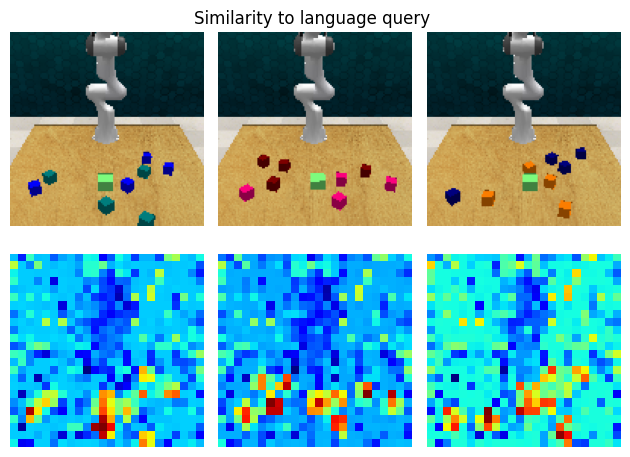

In [15]:
# plt_sims(image_paths, sims.squeeze(), paths=True)
plt_sims(imgs, sims.squeeze(), paths=False)

In [16]:
imgs[0].shape

(128, 128, 3)

# Get RLBench data